In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# AQI .csv file (daily)

In [7]:
df = pd.read_csv('daily_aqi_by_county_2023.csv')
print(df.columns)
df['State Name'].drop_duplicates() # Checking what values are stored
df['Category'].drop_duplicates()
# All states plus DC and Mexico included
# Note that 2023 files are only updated to around October

Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object')


0                                 Good
46                            Moderate
482     Unhealthy for Sensitive Groups
1004                         Unhealthy
1005                    Very Unhealthy
6794                         Hazardous
Name: Category, dtype: object

In [8]:
file1 = 'daily_aqi_by_county_2023.csv'
date1 = '2023-01-19'
state1 = 'Alabama'

# Test the function
# aqi_daily_finder(file1, date1, state1)

# Temperature .csv file (daily)

In [9]:
file2 = 'daily_TEMP_2023.csv'
df2 = pd.read_csv(file2) 
print(df2.columns)
df2['State Name'].drop_duplicates() # Missing 4 states: Delaware, NY, NJ, Vermont
df2['Units of Measure'].drop_duplicates() # All recorded in Farenheit
# df2['County Name'].head()

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'Arithmetic Mean',
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')


0    Degrees Fahrenheit
Name: Units of Measure, dtype: object

# Yearly summary functions:

In [10]:
def aqi_yearly_finder(file: str, year: str, state_name: str):
    '''
    Finds air quality index in an area for a given year
    Inputs: .csv file from aqs.epa.gov (str), date as YYYY (str), state name (str)   
    Returns: str
    '''
    df = pd.read_csv(file)
    
    # Find rows where date and state match
    chosen_year = df['Date'].str.slice(0,4) == year
    chosen_state = df['State Name'] == state_name
    
    # If date/state not found
    if not chosen_year.any():
        return f'Sorry, {year} is not recorded in this file.'
    elif not chosen_state.any():
        return f'Sorry, {state_name} is not recorded in this file. Note that Delaware is not recorded in this file. Check for any typos!'
    
    # Update dataframe with conditions
    df = df[chosen_year & chosen_state]
    
    # Values of interest:
    aqi = df['AQI'].values
    aqi_max = max(df['AQI'].values)
    aqi_mean = aqi.mean()
    
    # Determine count of categories recorded in the filtered data
    condition = df['Category'].value_counts()
    condition_count = ", ".join([f"{count} {category}" for category, count in condition.items() if count != 0])
        
    
    number_counties = len(df['county Name'].unique())
    
    recorded_days = len(df['Date'].unique())

    
    return f'The AQI in {state_name} in {year} was recorded for {number_counties} {state_name} counties,\
             and a total of {recorded_days} days were recorded. \
             The average AQI was {aqi_mean:.1f} and the maximum recorded AQI was {aqi_max:.1f}.\
             (AQI\'s over 100 are considered unhealthy for sensitive groups.)'
            
        


In [11]:
# Test function
aqi_yearly_finder(file1, '2023', 'Texas')

"The AQI in Texas in 2023 was recorded for 44 Texas counties,             and a total of 241 days were recorded.              The average AQI was 42.0 and the maximum recorded AQI was 279.0.             (AQI's over 100 are considered unhealthy for sensitive groups.)"

In [12]:
def temp_yearly_finder(file: str, year: str, state_name: str):
    '''
    Finds temperature in an area for the given year
    Inputs: .csv file from aqs.epa.gov (str), year as YYYY (str), state name (str)   
    Returns: str
    '''
    df = pd.read_csv(file)
    
    # Find rows where date and state match
    chosen_year = df['Date Local'].str.slice(0,4) == year
    chosen_state = df['State Name'] == state_name
    
    # If date/state not found
    if not chosen_year.any():
        return f'Sorry, {year} is not recorded in this file.'
        return f'Sorry, {state_name} is not recorded in this file. Note that the following have no available data: Delaware, New York, New Jersey, Vermont'
    
    # Update dataframe with conditions
    df = df[chosen_year & chosen_state]
    
    # Values of interest:
    recorded_days = len(df['Date Local'].unique())
    
    temp_max = max(df['1st Max Value'].values) # High of the year
    temp_mean = df['1st Max Value'].values.mean() # Mean of the year across all counties
    # Note: We found some temperatures that are obviously wrong (at least 1 over 200F in CA)
    
    number_counties = len(df['County Name'].unique())

        
    return f'The temperature in {state_name} was recorded across {number_counties} {state_name} counties, \
             and a total of {recorded_days} days were recorded in {year}. \
             The average temperature was {temp_mean:.1f} degrees Farenheit across {number_counties} counties. \
             The highest temperature recorded for {state_name} in {year} was {temp_max: .1f} degrees Farenheit.'
            
    

In [13]:
# Test the function
temp_yearly_finder(file2, '2023', 'Massachusetts')

'The temperature in Massachusetts was recorded across 10 Massachusetts counties,              and a total of 181 days were recorded in 2023.              The average temperature was 55.9 degrees Farenheit across 10 counties.              The highest temperature recorded for Massachusetts in 2023 was  100.0 degrees Farenheit.'

# Yearly plots

In [63]:
def aqi_yearly_plot(file: str, year: str, state: str):
    '''
    Plots air quality of each day recorded in given year
    Inputs: .csv file from aqs.epa.gov (str), date as YYYY (str), state name (str)   
    Returns: plot
    '''
    df = pd.read_csv(file)
    
    # Find rows where date and state match
    chosen_year = df['Date'].str.slice(0,4) == year
    chosen_state = df['State Name'] == state
    
    # If date/state not found
    if not chosen_year.any():
        return f'Sorry, {year} is not recorded in this file.'
    elif not chosen_state.any():
        return f'Sorry, {state} is not recorded in this file. Note that Delaware is not recorded in this file. Check for any typos!'
    
    # Update dataframe with conditions
    df = df[chosen_year & chosen_state]
    
    # Find average across all counties that record a single day for a daily average:
    
    daily_avg = df.groupby('Date')['AQI'].mean().tolist()
    daily_max = df.groupby('Date')['AQI'].max().tolist()

    number_counties = len(df['county Name'].unique())
    
    unique_days = df['Date'].str.slice(5).unique() # For x-ticks, we don't need the year to show

    # Plotting
    plt.figure(figsize = (10,8))
    plt.rcParams['figure.dpi'] = 500
    plt.plot(unique_days, daily_avg, color='steelblue', label='Daily Average')
    plt.plot(unique_days,  daily_max, color='lightcoral', label='Daily Maximum')
    plt.axhline(y=100, color='black', linestyle='--', label='Unhealthy AQI')
    plt.axhline(y=50, color='orange', linestyle='--', label='Moderate AQI')
    plt.ylabel('Air Quality Index', fontsize=12)
    plt.xlabel('Date')
    plt.xticks(range(0, len(unique_days), 30), rotation=25, fontsize=10)
    plt.legend()
    plt.title(f'{year} Air Quality Across {number_counties} Counties in {state}')
    plt.show()
    
    
    

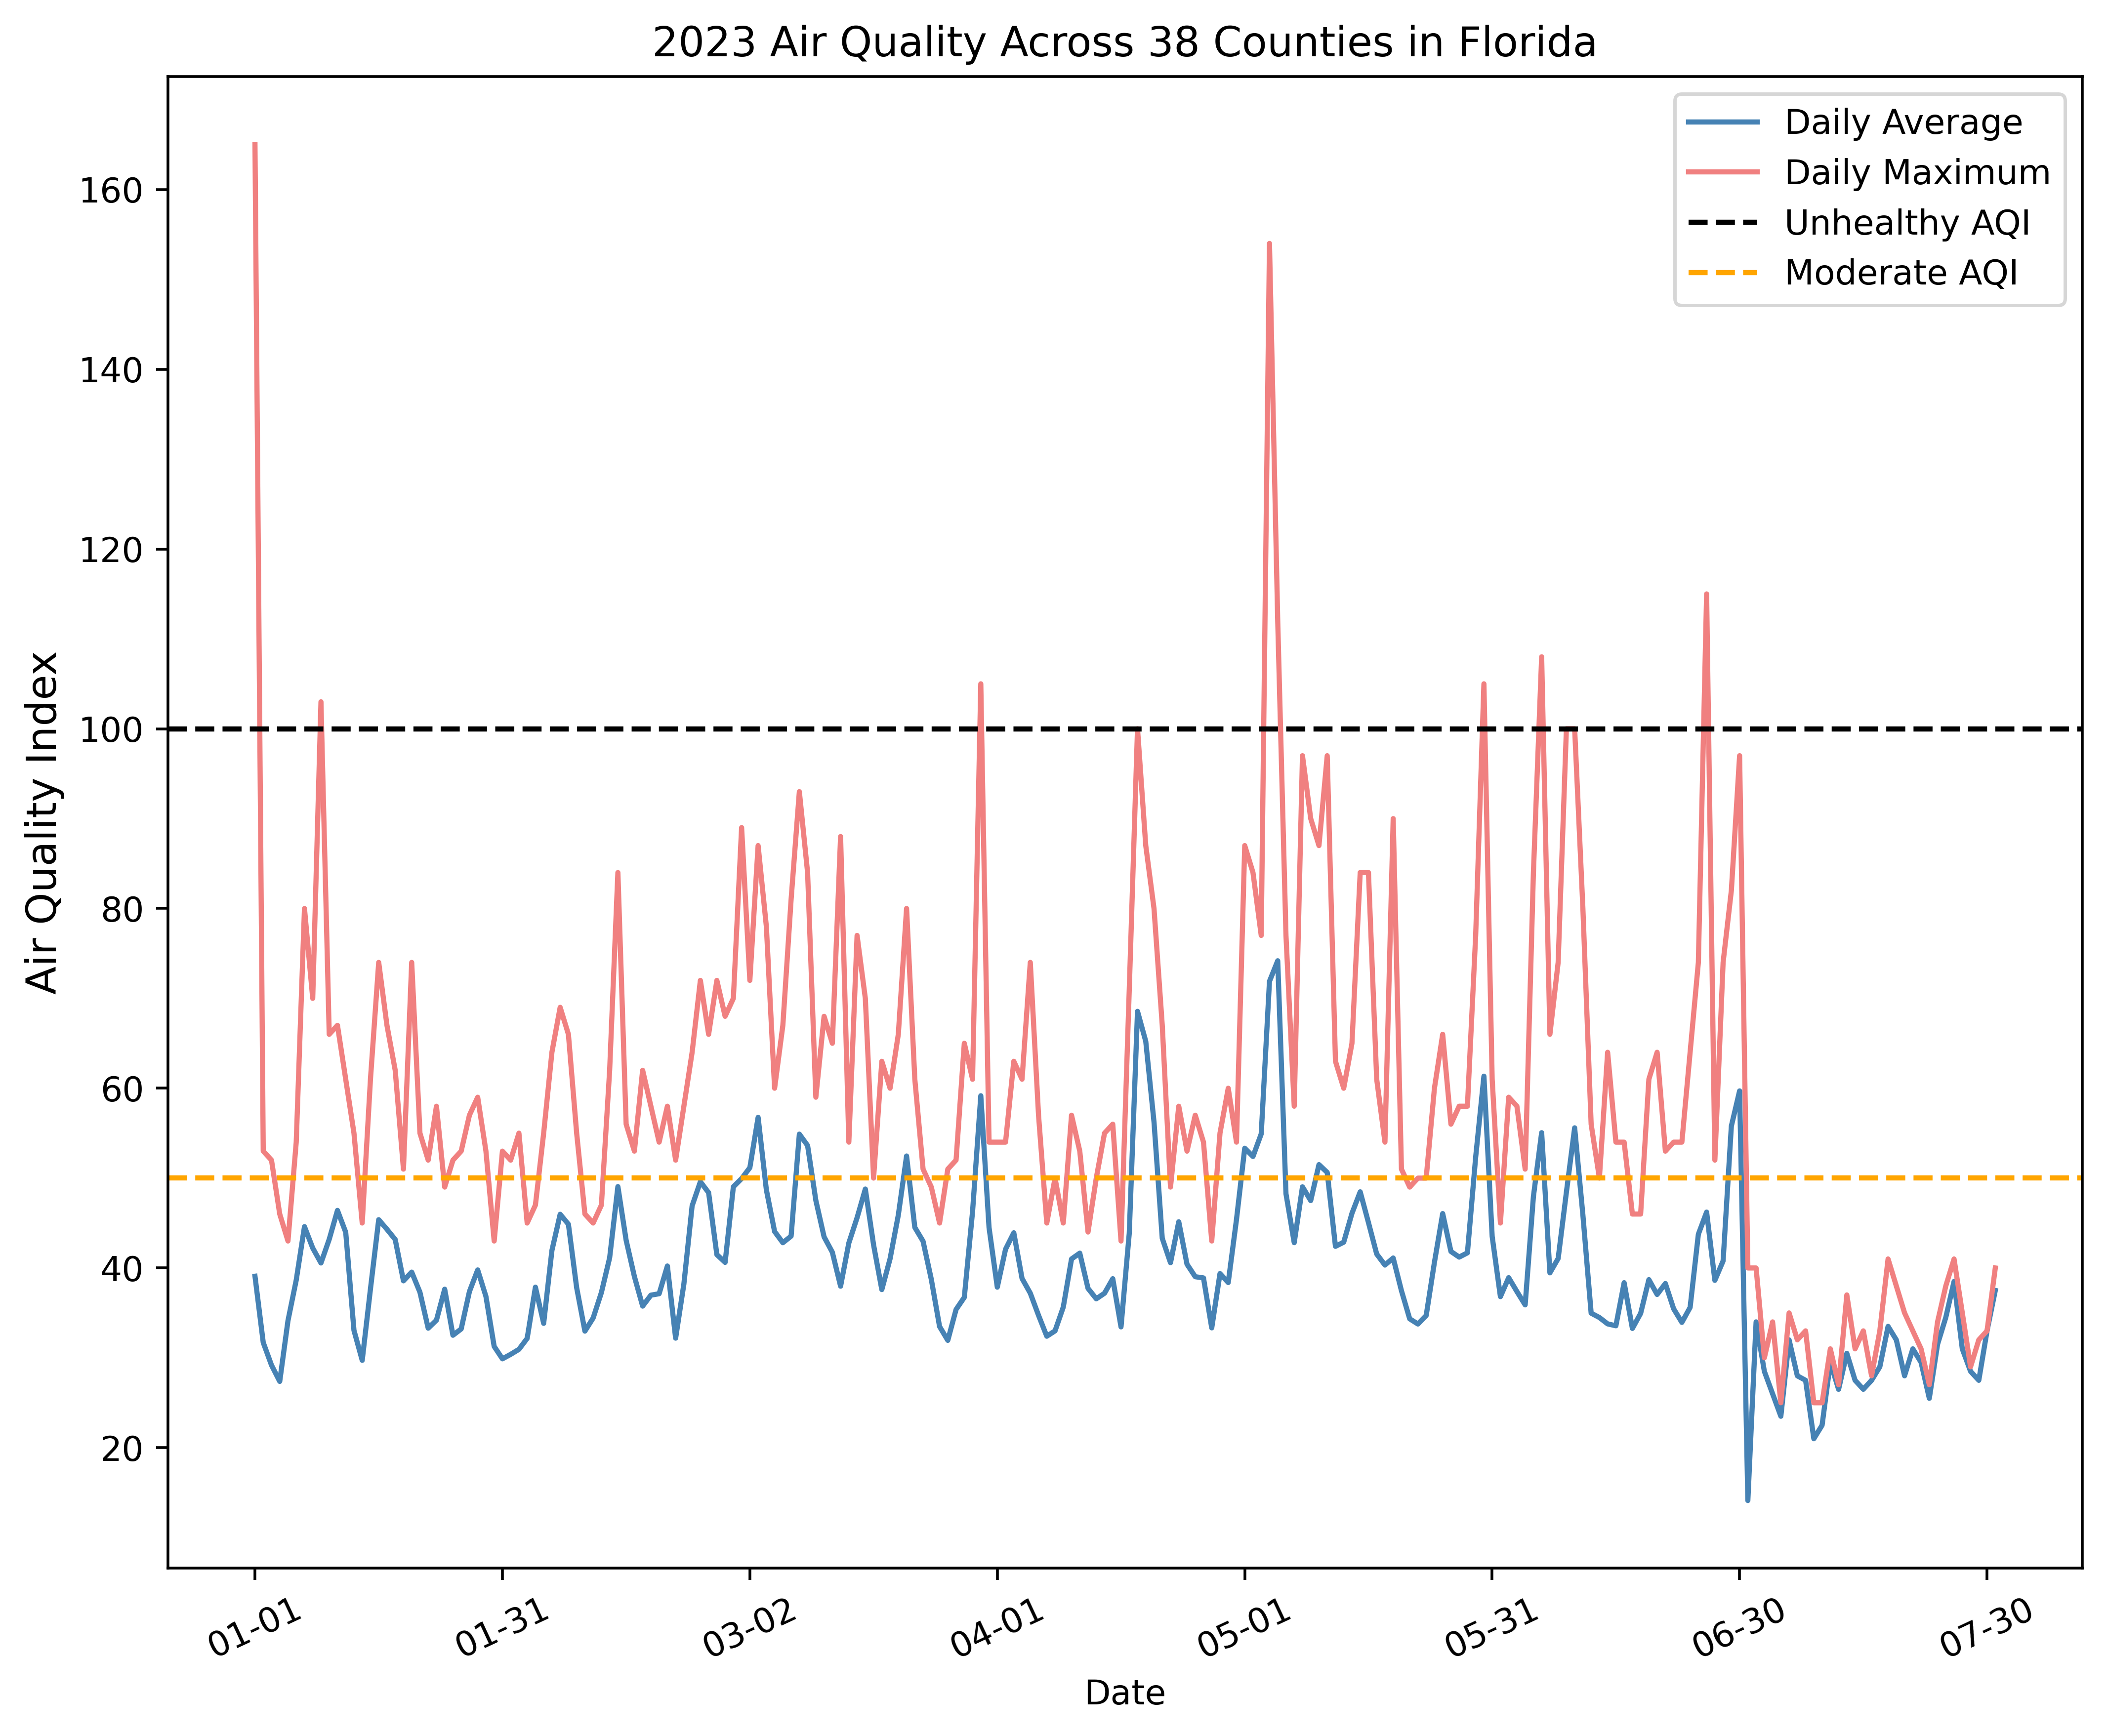

In [64]:
aqi_yearly_plot(file1, '2023', 'Florida')

In [86]:
def temp_yearly_plot(file: str, year: str, state_name: str):
    '''
    Plots temperature of each day recorded in given year and place
    Inputs: .csv file from aqs.epa.gov (str), date as YYYY (str), state name (str)   
    Returns: plot
    '''
    df = pd.read_csv(file)
    
    # Find rows where date and state match
    chosen_year = df['Date Local'].str.slice(0,4) == year
    chosen_state = df['State Name'] == state_name
    
    # If date/state not found
    if not chosen_year.any():
        return f'Sorry, {year} is not recorded in this file.'
    elif not chosen_state.any():
        return f'Sorry, {state_name} is not recorded in this file. Note that the following have no available data: Delaware, New York, New Jersey, Vermont'
    
    # Update dataframe with conditions
    df = df[chosen_year & chosen_state]
    
    # Find average across all counties that record a single day for a daily average:
    
    daily_avg = df.groupby('Date Local')['1st Max Value'].mean().tolist()
    daily_max = df.groupby('Date Local')['1st Max Value'].max().tolist()

    number_counties = len(df['County Name'].unique())
    
    unique_days = df['Date Local'].str.slice(5).unique() # For x-ticks, we don't need the year to show

    # Plotting
    plt.figure(figsize = (10,8))
    plt.rcParams['figure.dpi'] = 500
    plt.plot(unique_days, daily_avg, color='steelblue', label='Daily Average')
    plt.plot(unique_days,  daily_max, color='goldenrod', label='Daily Maximum')
    plt.ylabel('Temperature (Degrees Farenheit)', fontsize=12)
    plt.xlabel('Date')
    plt.xticks(range(0, len(unique_days), 30), rotation=25, fontsize=10)
    plt.legend()
    plt.title(f'{year} Temperatures Across {number_counties} Counties in {state_name}')
    plt.show()
    

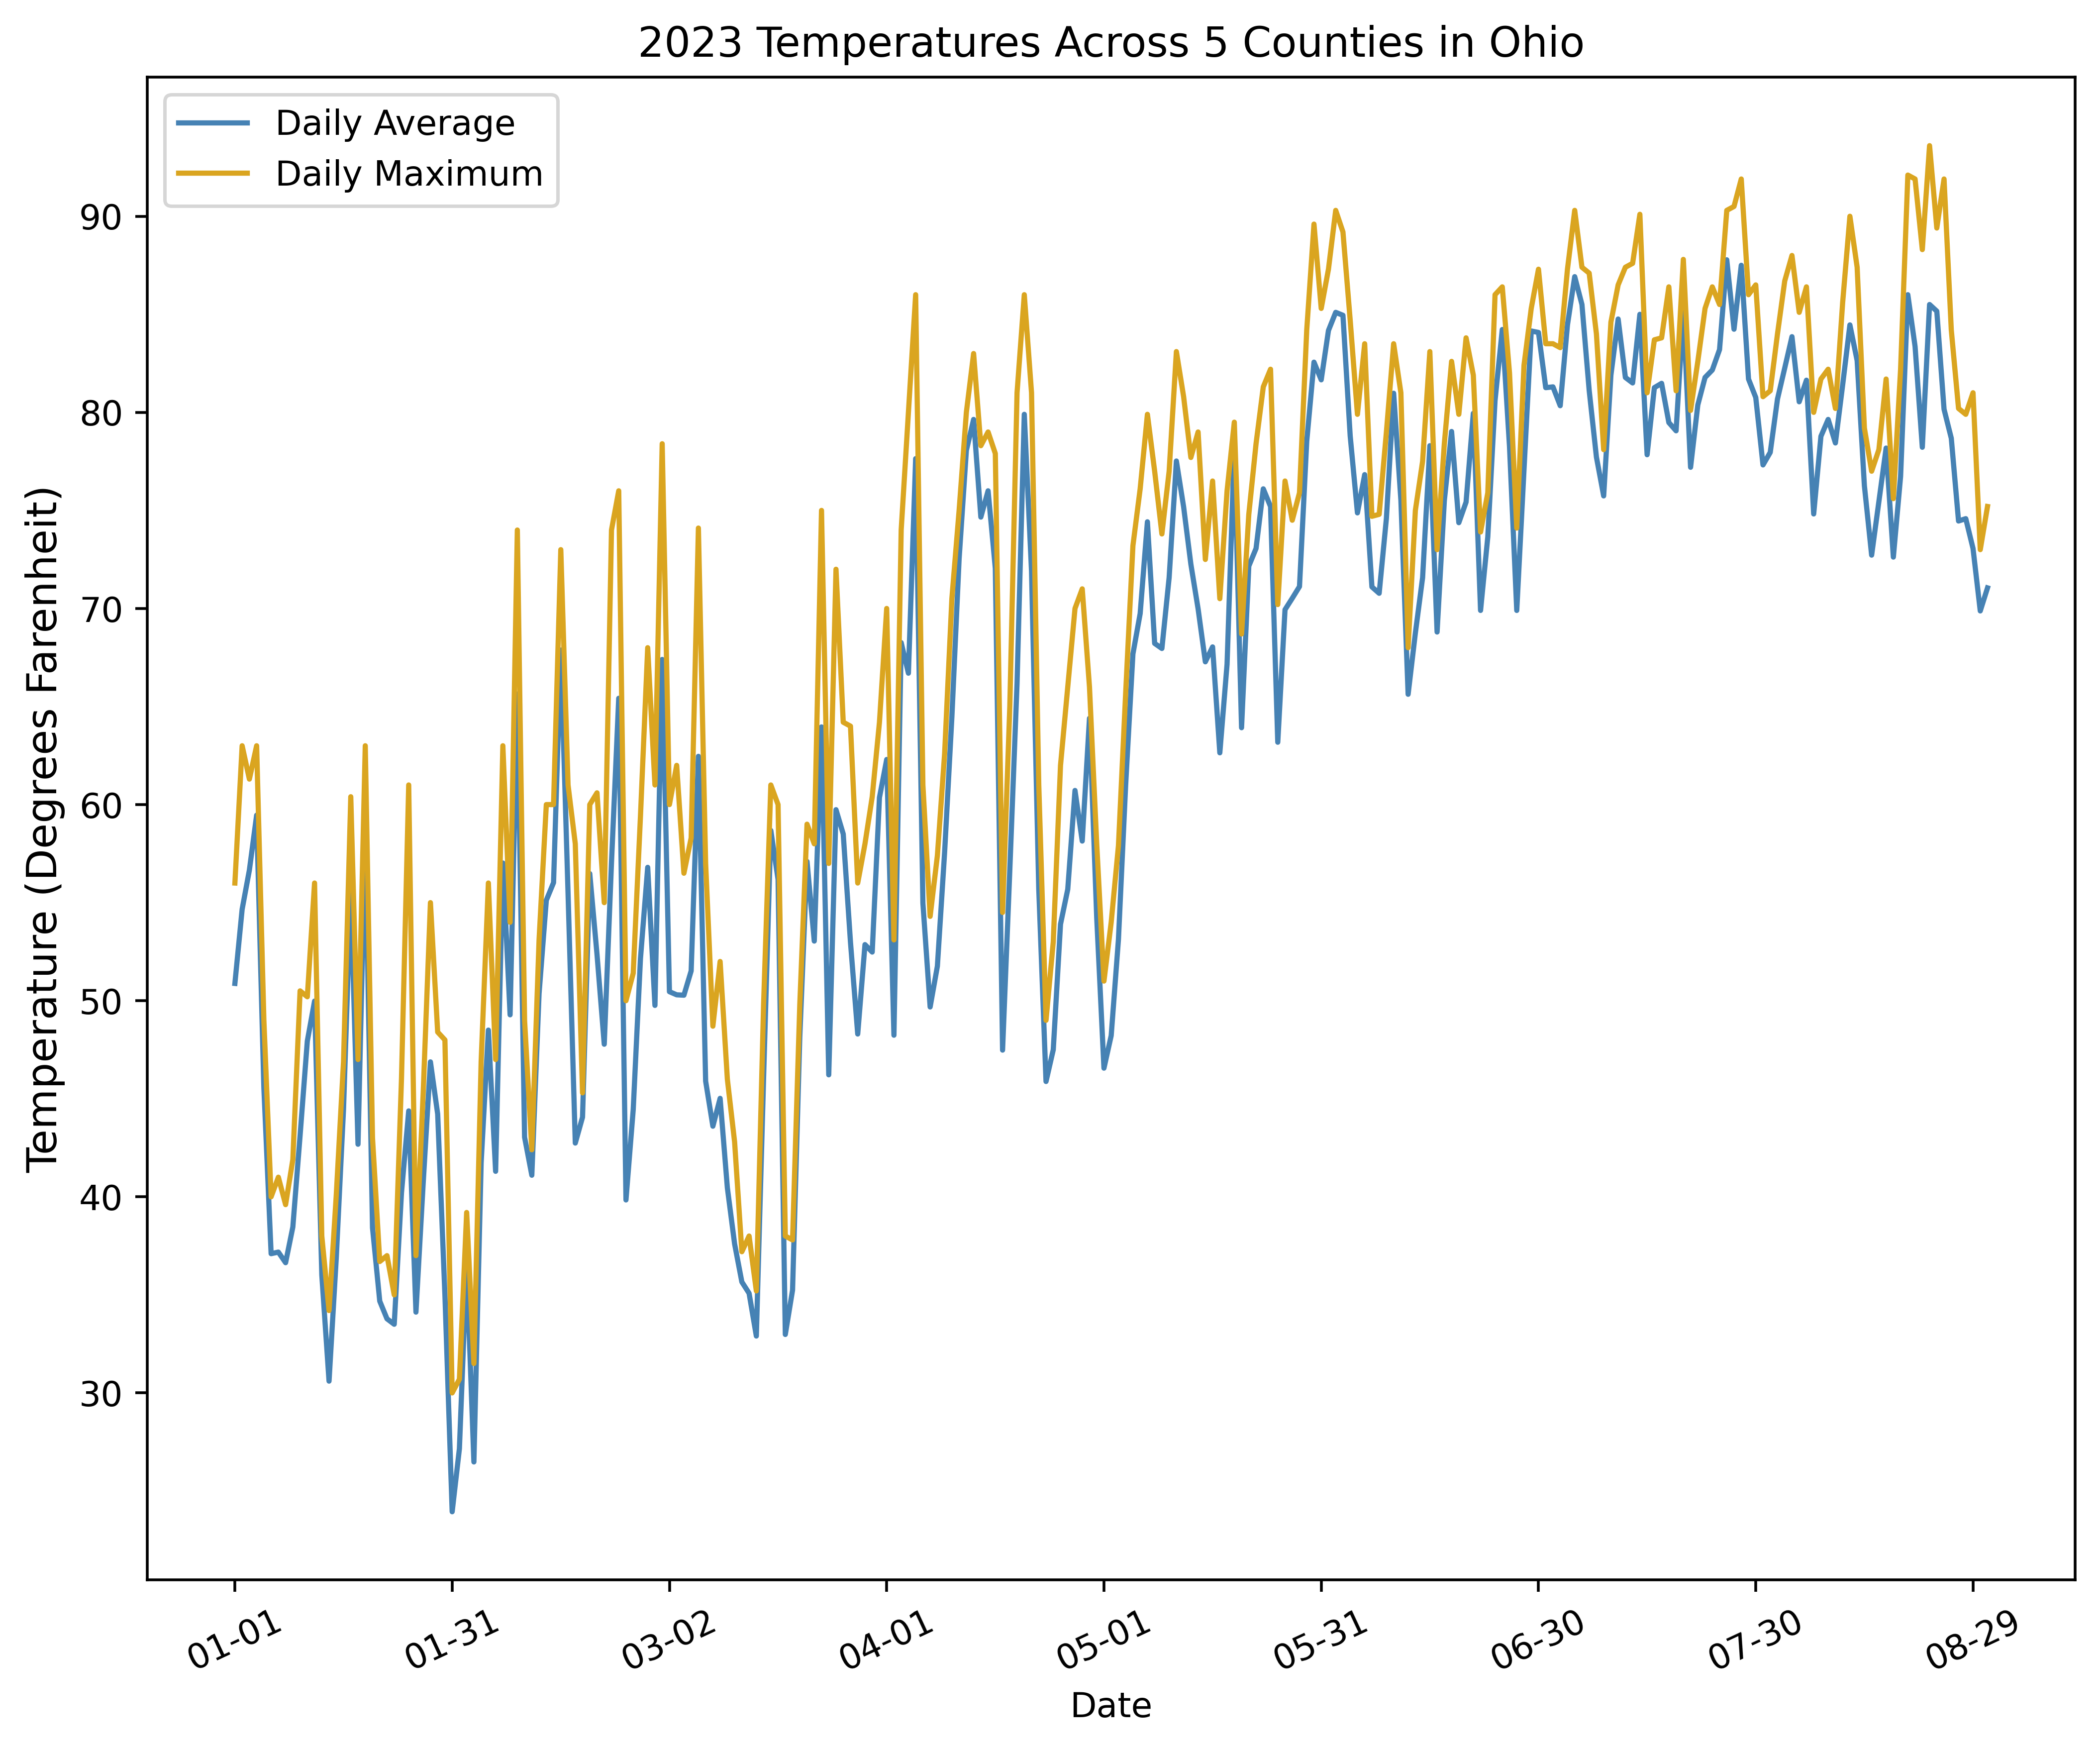

In [88]:
temp_yearly_plot(file2, '2023', 'Ohio')

In [81]:
# Pollutants plot

In [417]:
ozone = 'daily_44201_2023.csv'
co2 = 'daily_42101_2023.csv'
so2 = 'daily_42401_2023.csv'
no2 = 'daily_42602_2023.csv'
l = pd.read_csv(no2)
l['State Name'].unique()

array(['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'District Of Columbia', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'Wisconsin', 'Wyoming', 'Puerto Rico'], dtype=object)

In [419]:
def criteria_gases_plot(ozone_file: str, co2_file:str, so2_file:str, no2_file:str, year: str, state: str):
    '''
    Plots detection of criteria gases of each day recorded in given year and place
    Inputs: 4 .csv files from aqs.epa.gov (str), date as YYYY (str), state name (str)   
    Returns: plot
    '''
    ozone = pd.read_csv(ozone_file)
    co2 = pd.read_csv(co2_file)
    so2 = pd.read_csv(so2_file)
    no2 = pd.read_csv(no2_file)
    
    
    # Find rows where date and state match
    chosen_year_ozone = ozone['Date Local'].str.slice(0,4) == year
    chosen_state_ozone = ozone['State Name'] == state
    
    chosen_year_co2 = co2['Date Local'].str.slice(0,4) == year
    chosen_state_co2 = co2['State Name'] == state
    
    chosen_year_so2 = so2['Date Local'].str.slice(0,4) == year
    chosen_state_so2 = so2['State Name'] == state
    
    chosen_year_no2 = no2['Date Local'].str.slice(0,4) == year
    chosen_state_no2 = no2['State Name'] == state
    
    
    # If date/state not found
    if not (chosen_year_ozone.any() and chosen_year_co2.any() and chosen_year_so2.any() and chosen_year_no2.any()):
        return f'Sorry, {year} is not recorded in all necessary files.'
    elif not (chosen_state_ozone.any() and chosen_state_co2.any() and chosen_state_so2.any() and chosen_state_no2.any()):
        return f'Sorry, {state} is not recorded in all necessary files. Note that the following have no available data: Alaska, Delaware'
    
    # Update dataframes with conditions
    ozone = ozone[chosen_year_ozone & chosen_state_ozone]
    co2 = co2[chosen_year_co2 & chosen_state_co2]
    so2 = so2[chosen_year_so2 & chosen_state_so2]
    no2 = no2[chosen_year_no2 & chosen_state_no2]

    
    # Find average across all counties that record a single day for a daily average:
    
    daily_avg_ozone = ozone.groupby('Date Local')['Observation Count'].mean().tolist()
    
    daily_avg_co2 = co2.groupby('Date Local')['Observation Count'].mean().tolist()
    
    daily_avg_so2 = so2.groupby('Date Local')['Observation Count'].mean().tolist()

    daily_avg_no2 = no2.groupby('Date Local')['Observation Count'].mean().tolist()
    
    # We want to plot each day only once on our graph
    unique_days_ozone = ozone['Date Local'].str.slice(5).unique() # For x-ticks, we don't need the year to show
    unique_days_co2 = co2['Date Local'].str.slice(5).unique()
    unique_days_so2 = so2['Date Local'].str.slice(5).unique()
    unique_days_no2 = no2['Date Local'].str.slice(5).unique()
    
    # Plotting
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=500)

    axs[0, 0].plot(unique_days_ozone, daily_avg_ozone, color='orange')
    axs[0, 0].set_title(f'Ozone observed in {state} {year}')
    axs[0, 0].set_xticks(range(0, len(unique_days_ozone), 30))
    axs[0, 0].set_ylabel('Observation Count (parts per million)')
    axs[0, 0].set_xlabel('Date')

    
    axs[0, 1].plot(unique_days_co2, daily_avg_co2, color='forestgreen')
    axs[0, 1].set_title(f'CO2 observed in {state} {year}')
    axs[0, 1].set_xticks(range(0, len(unique_days_co2), 30))
    axs[0, 1].set_ylabel('Observation Count (parts per million)')
    axs[0, 1].set_xlabel('Date')
    
    axs[1, 0].plot(unique_days_so2, daily_avg_so2, color='steelblue')
    axs[1, 0].set_title(f'SO2 observed in {state} {year}')
    axs[1, 0].set_xticks(range(0, len(unique_days_so2), 30))
    axs[1, 0].set_ylabel('Observation Count (parts per million)')
    axs[1, 0].set_xlabel('Date')
    
    axs[1, 1].plot(unique_days_no2, daily_avg_no2, color='brown')
    axs[1, 1].set_title(f'NO2 observed in {state} {year}')
    axs[1, 1].set_xticks(range(0, len(unique_days_no2), 30))
    axs[1, 1].set_ylabel('Observation Count (parts per million)')
    axs[1, 1].set_xlabel('Date')
    
    plt.tight_layout()
    plt.show()
    

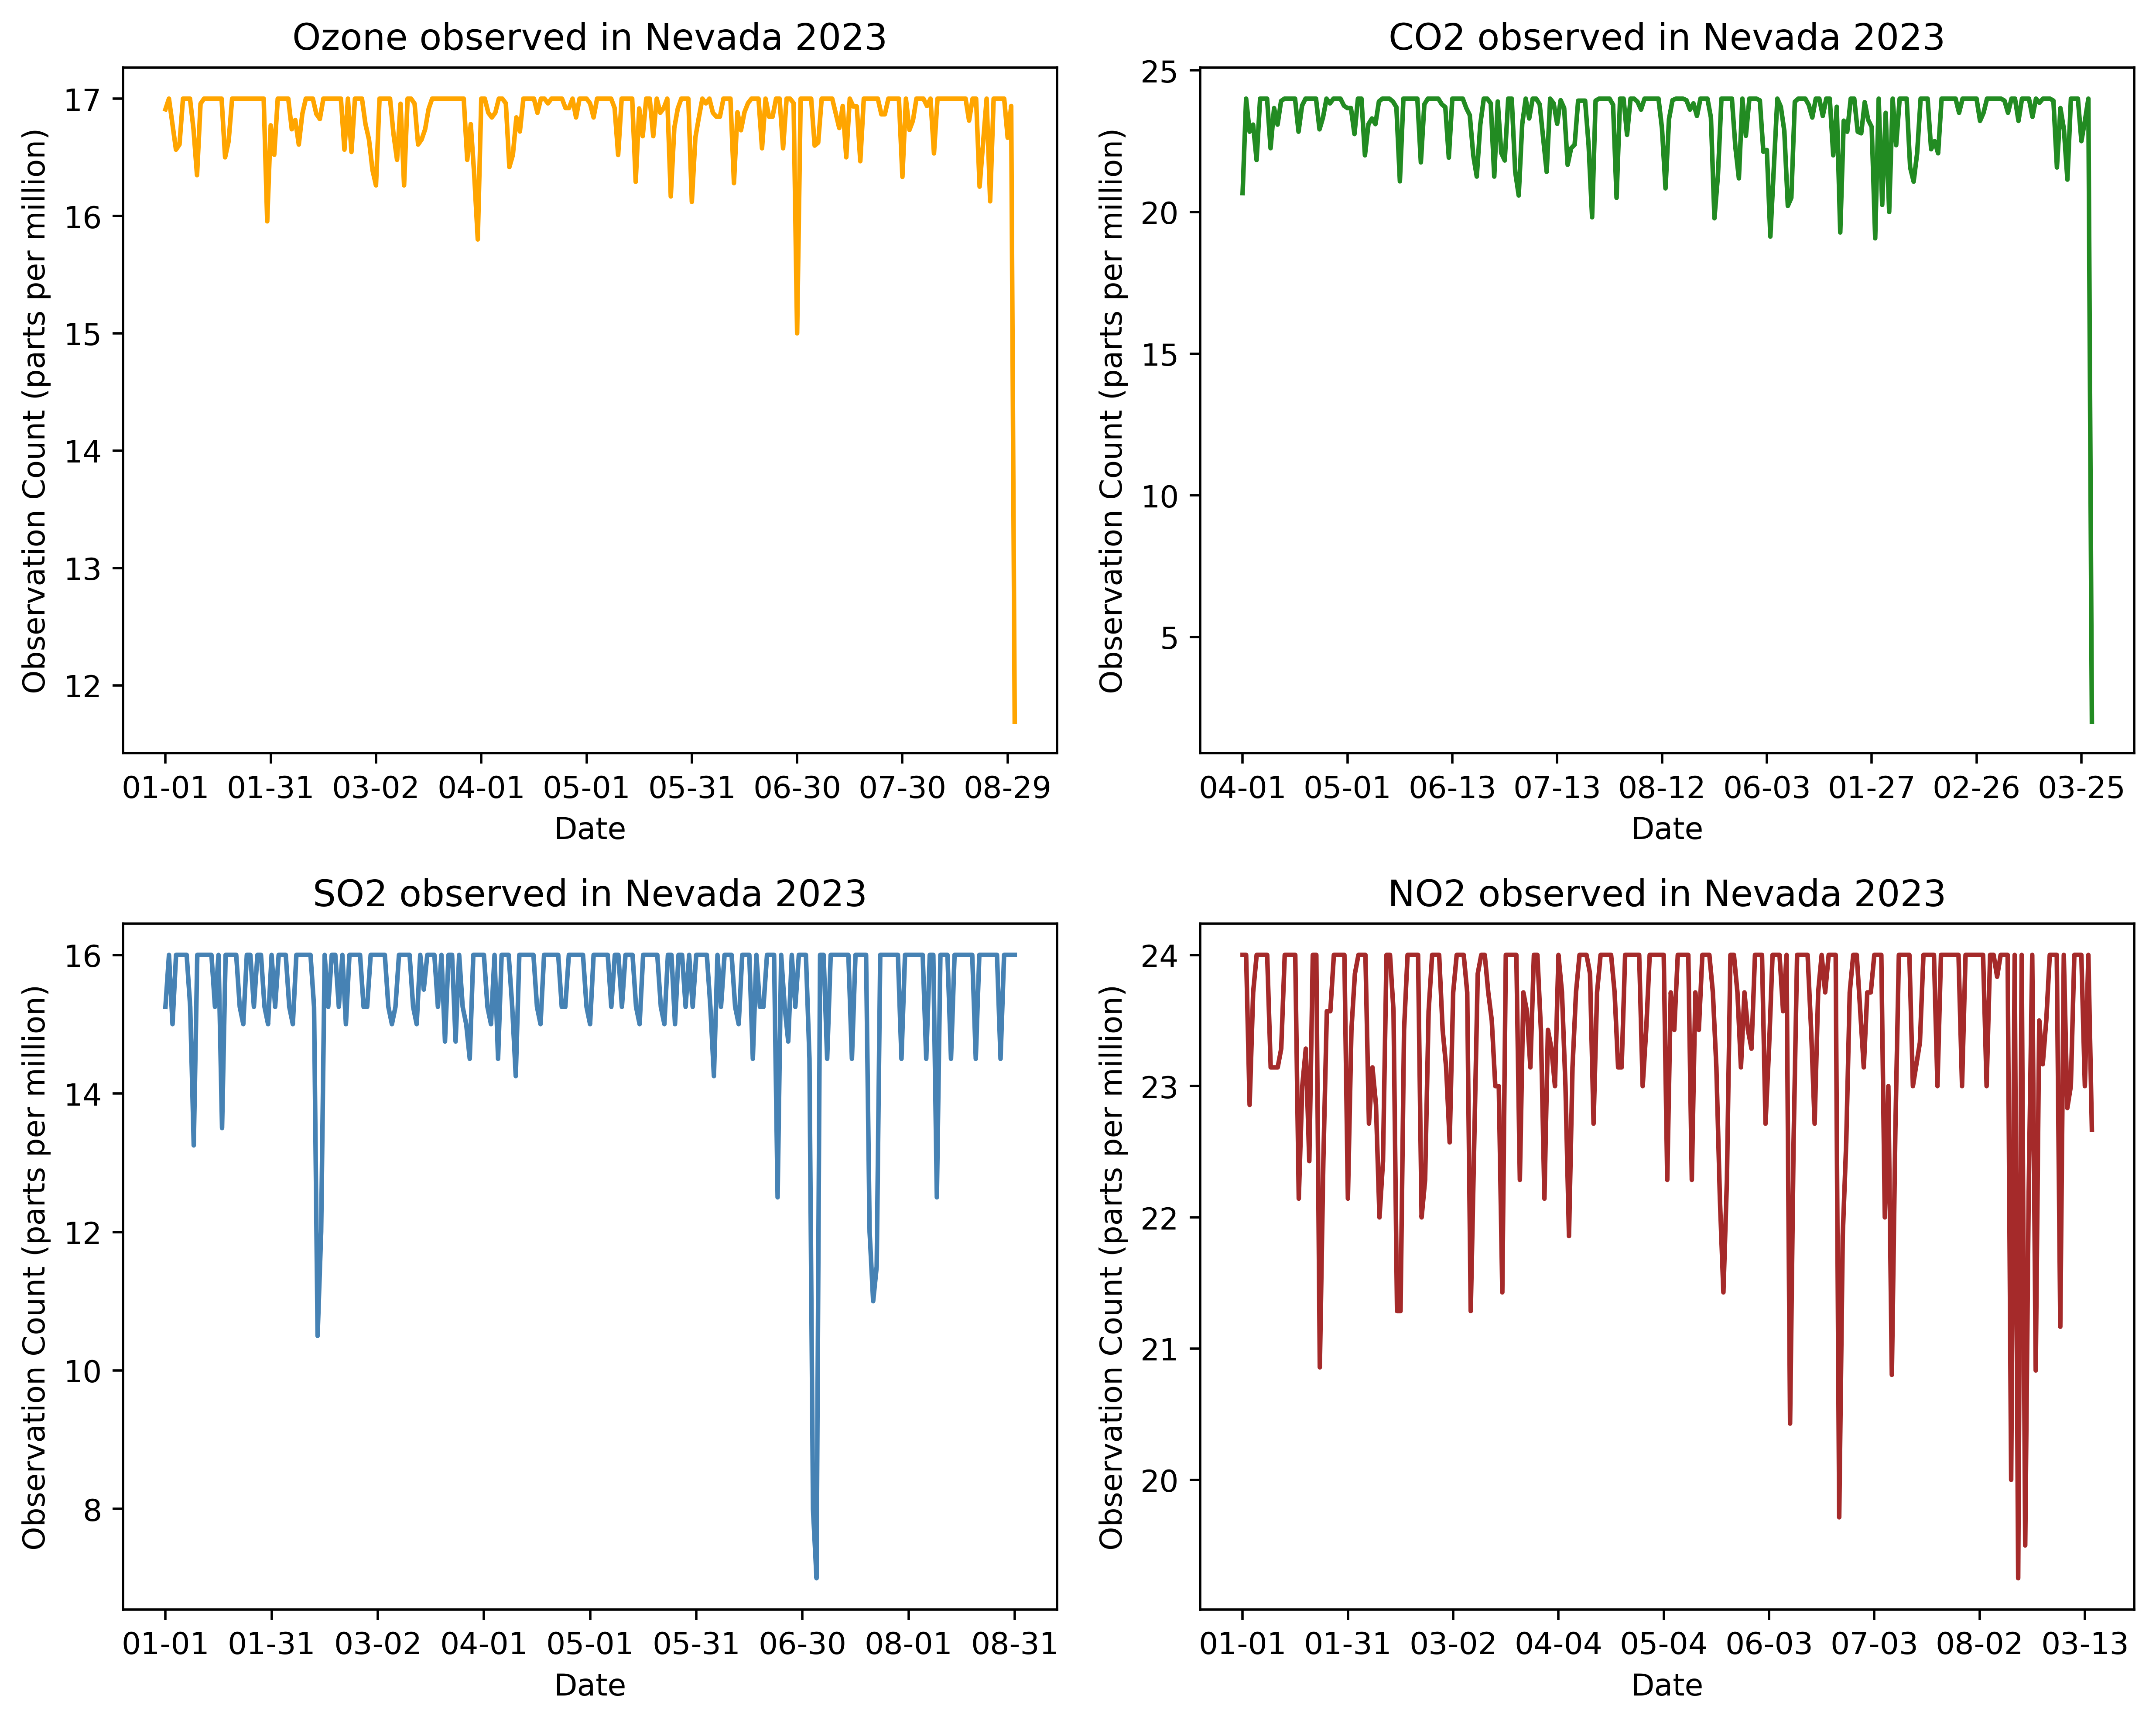

In [421]:
# Test function
criteria_gases_plot(ozone, co2, so2, no2, '2023', 'Nevada')

In [30]:
file22 = 'daily_aqi_by_county_2022.csv'

# Comparing states:

In [106]:
def aqi_states_plot(file: str, year: str):
    '''
    Plots average air quality of all states in given year
    Inputs: .csv file from aqs.epa.gov (str), date as YYYY (str)
    Returns: plot
    '''
    df = pd.read_csv(file)
    
    # Find rows where date and state match
    chosen_year = df['Date'].str.slice(0,4) == year
    
    # If date/state not found
    if not chosen_year.any():
        return f'Sorry, {year} is not recorded in this file.'
    
    # Update dataframe with conditions
    df = df[chosen_year]
    
    # Find average of each state for the whole year
#     yearly_max = df.groupby('State Name')['AQI'].max().tolist()
    yearly_avg = df.groupby('State Name')['AQI'].mean().tolist()
    
    unique_states = df['State Name'].unique() 
    number_states = len(unique_states)


    # Plotting
    plt.figure(figsize = (10,8))
    plt.rcParams['figure.dpi'] = 500
#     plt.bar(unique_states, yearly_max, color='lightcoral', label='Maximum AQI Recorded')
    plt.bar(unique_states, yearly_avg, color='lightblue')
    plt.axhline(y=50, color='orange', linestyle='--', label='Moderate AQI')
#     plt.axhline(y=100, color='black', linestyle='--', label='Unhealthy AQI')
    plt.grid(axis='y', linestyle='--', alpha=0.7)


    # Title and axes 
    plt.ylabel('Air Quality Index', fontsize=12)
    plt.xlabel('State / Country')
    plt.xticks(unique_states, rotation=90, fontsize=10)
    plt.legend()
    plt.title(f'Average Air Quality Recorded Across {number_states} Regions in {year}')
    plt.show()
    
    
    

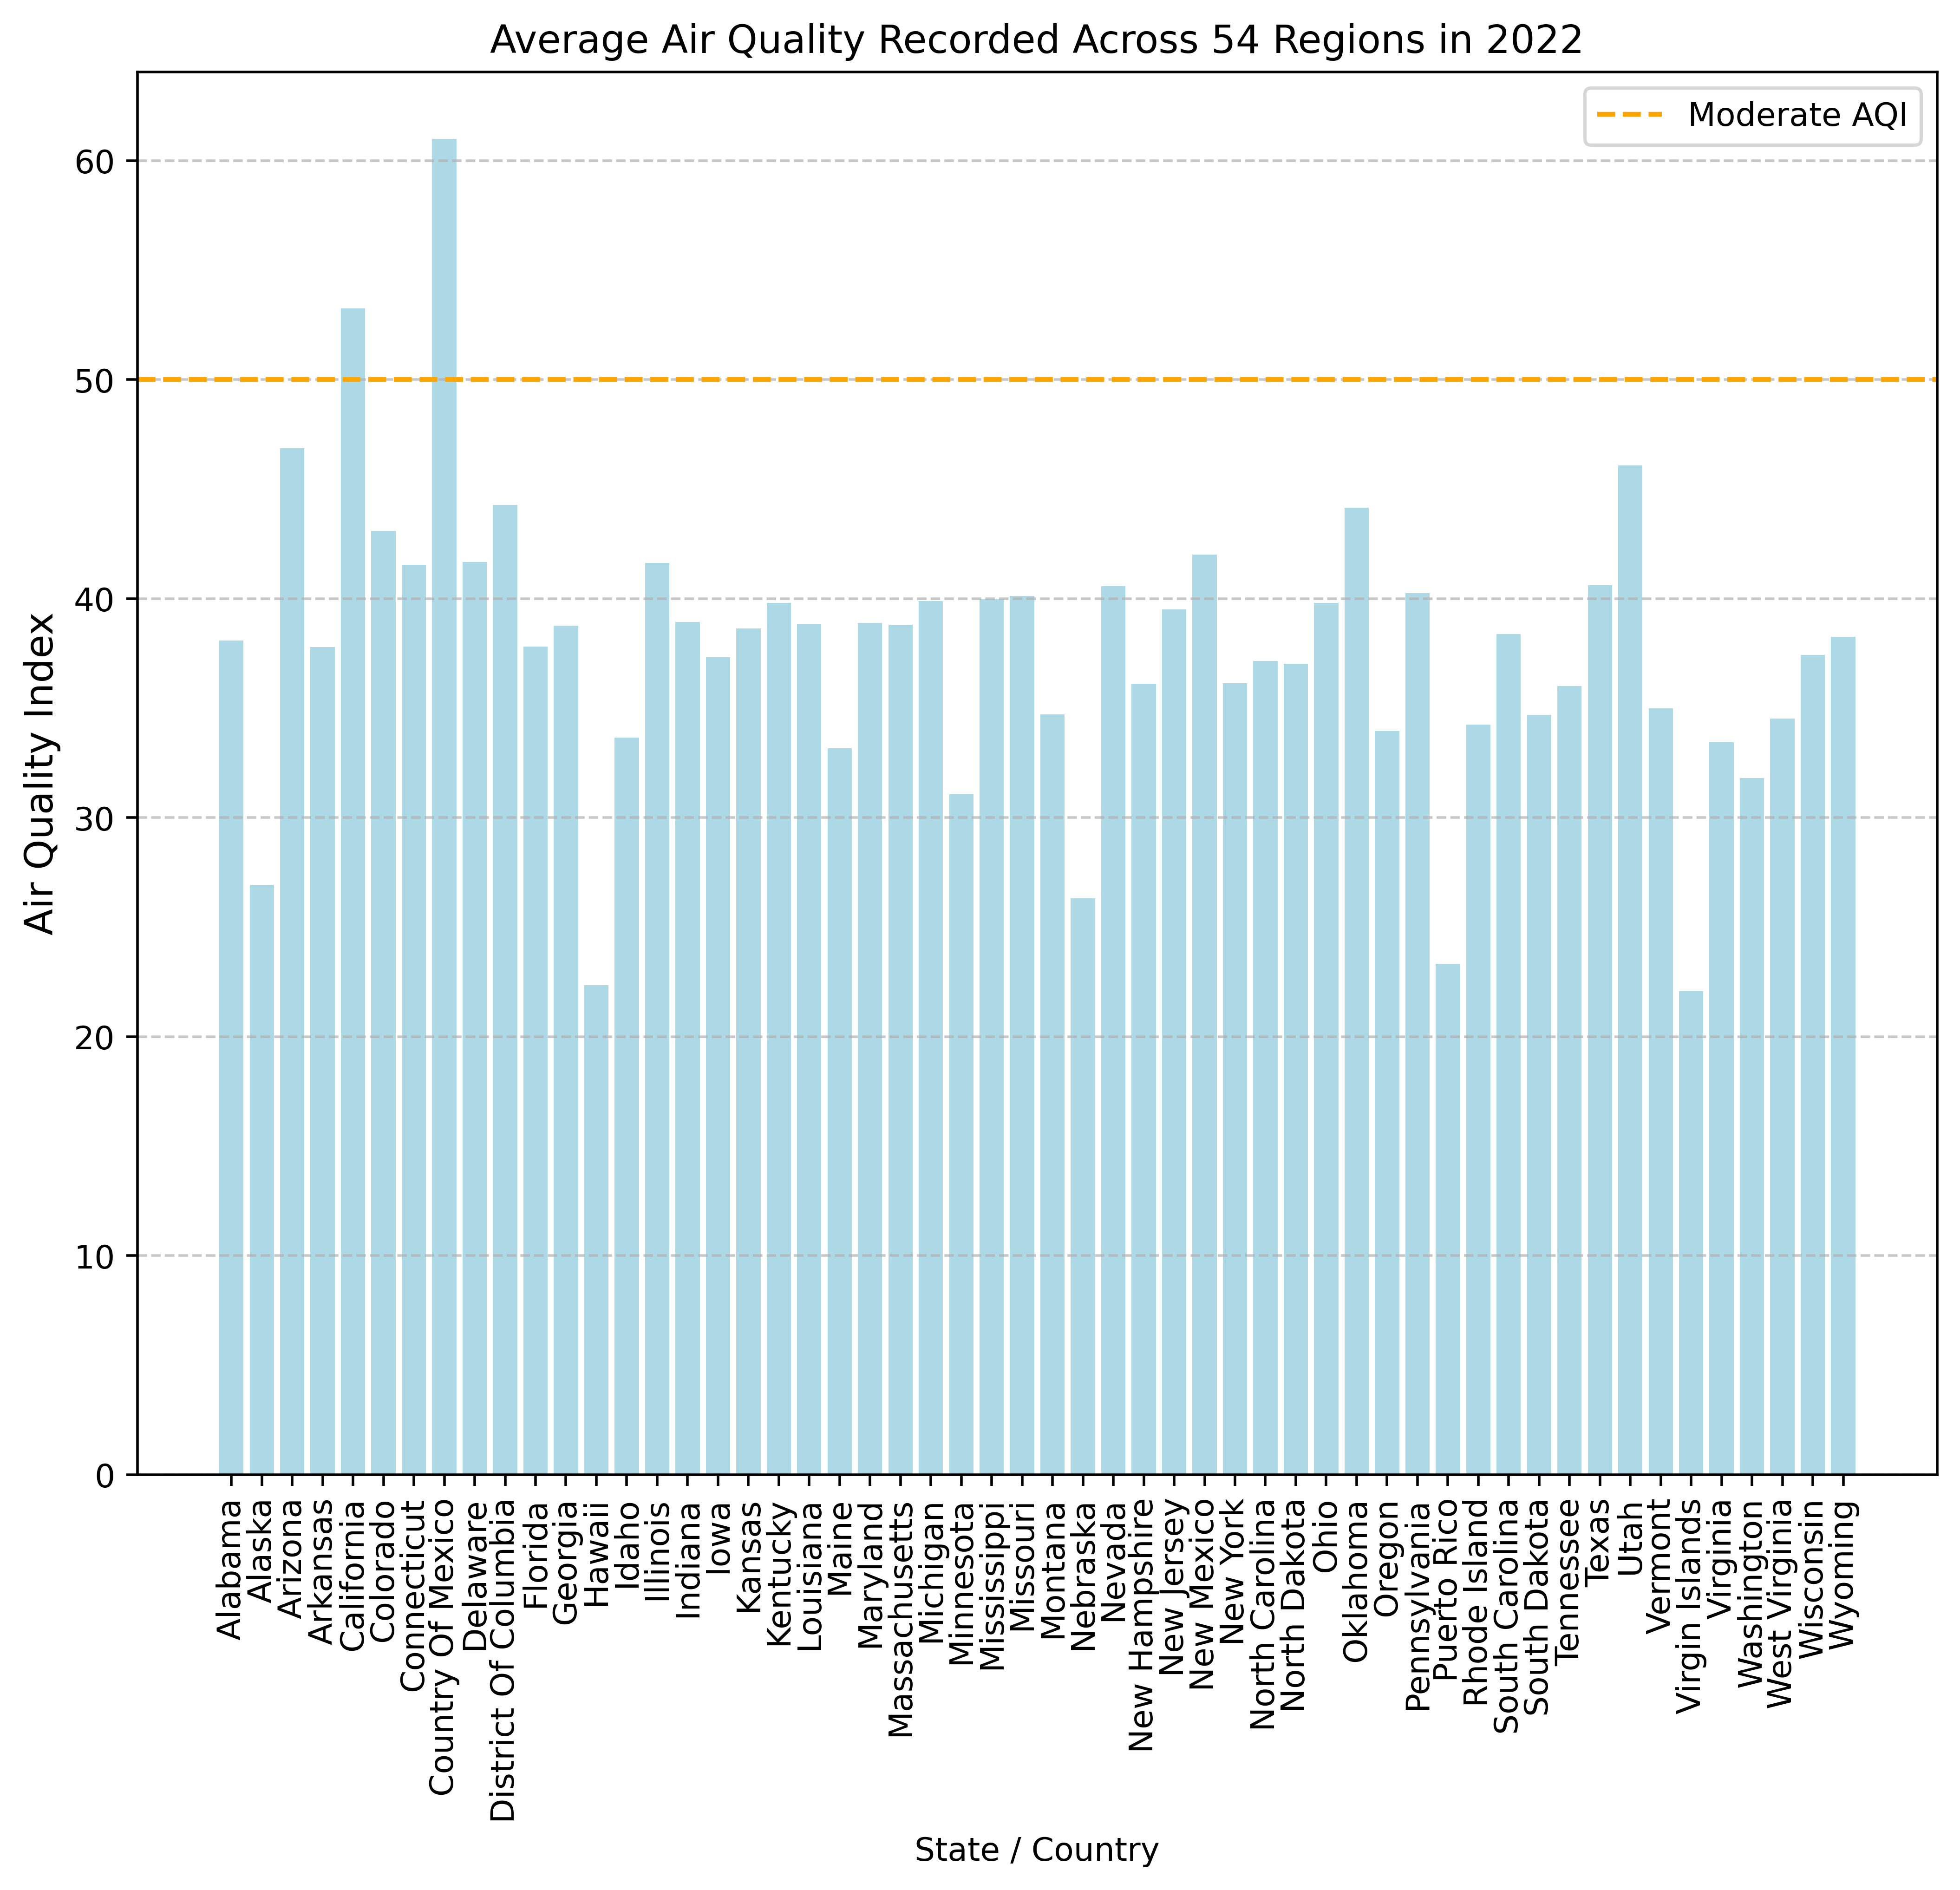

In [107]:
# Test function
qi_states_plot(file22, '2022')

In [104]:
def temp_states_plot(file: str, year: str):
    '''
    Plots average temperature of all states in given year
    Inputs: .csv file from aqs.epa.gov (str), date as YYYY (str)
    Returns: plot
    '''
    df = pd.read_csv(file)
    
    # Find rows where date and state match
    chosen_year = df['Date Local'].str.slice(0,4) == year
    
    # If date/state not found
    if not chosen_year.any():
        return f'Sorry, {year} is not recorded in this file.'
    
    # Update dataframe with conditions
    df = df[chosen_year]
    
    # Find average of each state for the whole year
#     yearly_max = df.groupby('State Name')['AQI'].max().tolist()
    yearly_avg = df.groupby('State Name')['1st Max Value'].mean().tolist()
    
    unique_states = df['State Name'].unique() 
    number_states = len(unique_states)


    # Plotting
    plt.figure(figsize = (10,8))
    plt.rcParams['figure.dpi'] = 500
    plt.bar(unique_states, yearly_avg, color='steelblue', label='Average Temperature')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Title and axes 
    plt.ylabel('Temperature (Degrees Farenheit)', fontsize=12)
    plt.xlabel('State / Country')
    plt.xticks(unique_states, rotation=90, fontsize=10)
    plt.title(f'Average Temperature Recorded Across {number_states} Regions in {year}')
    plt.show()
    
    

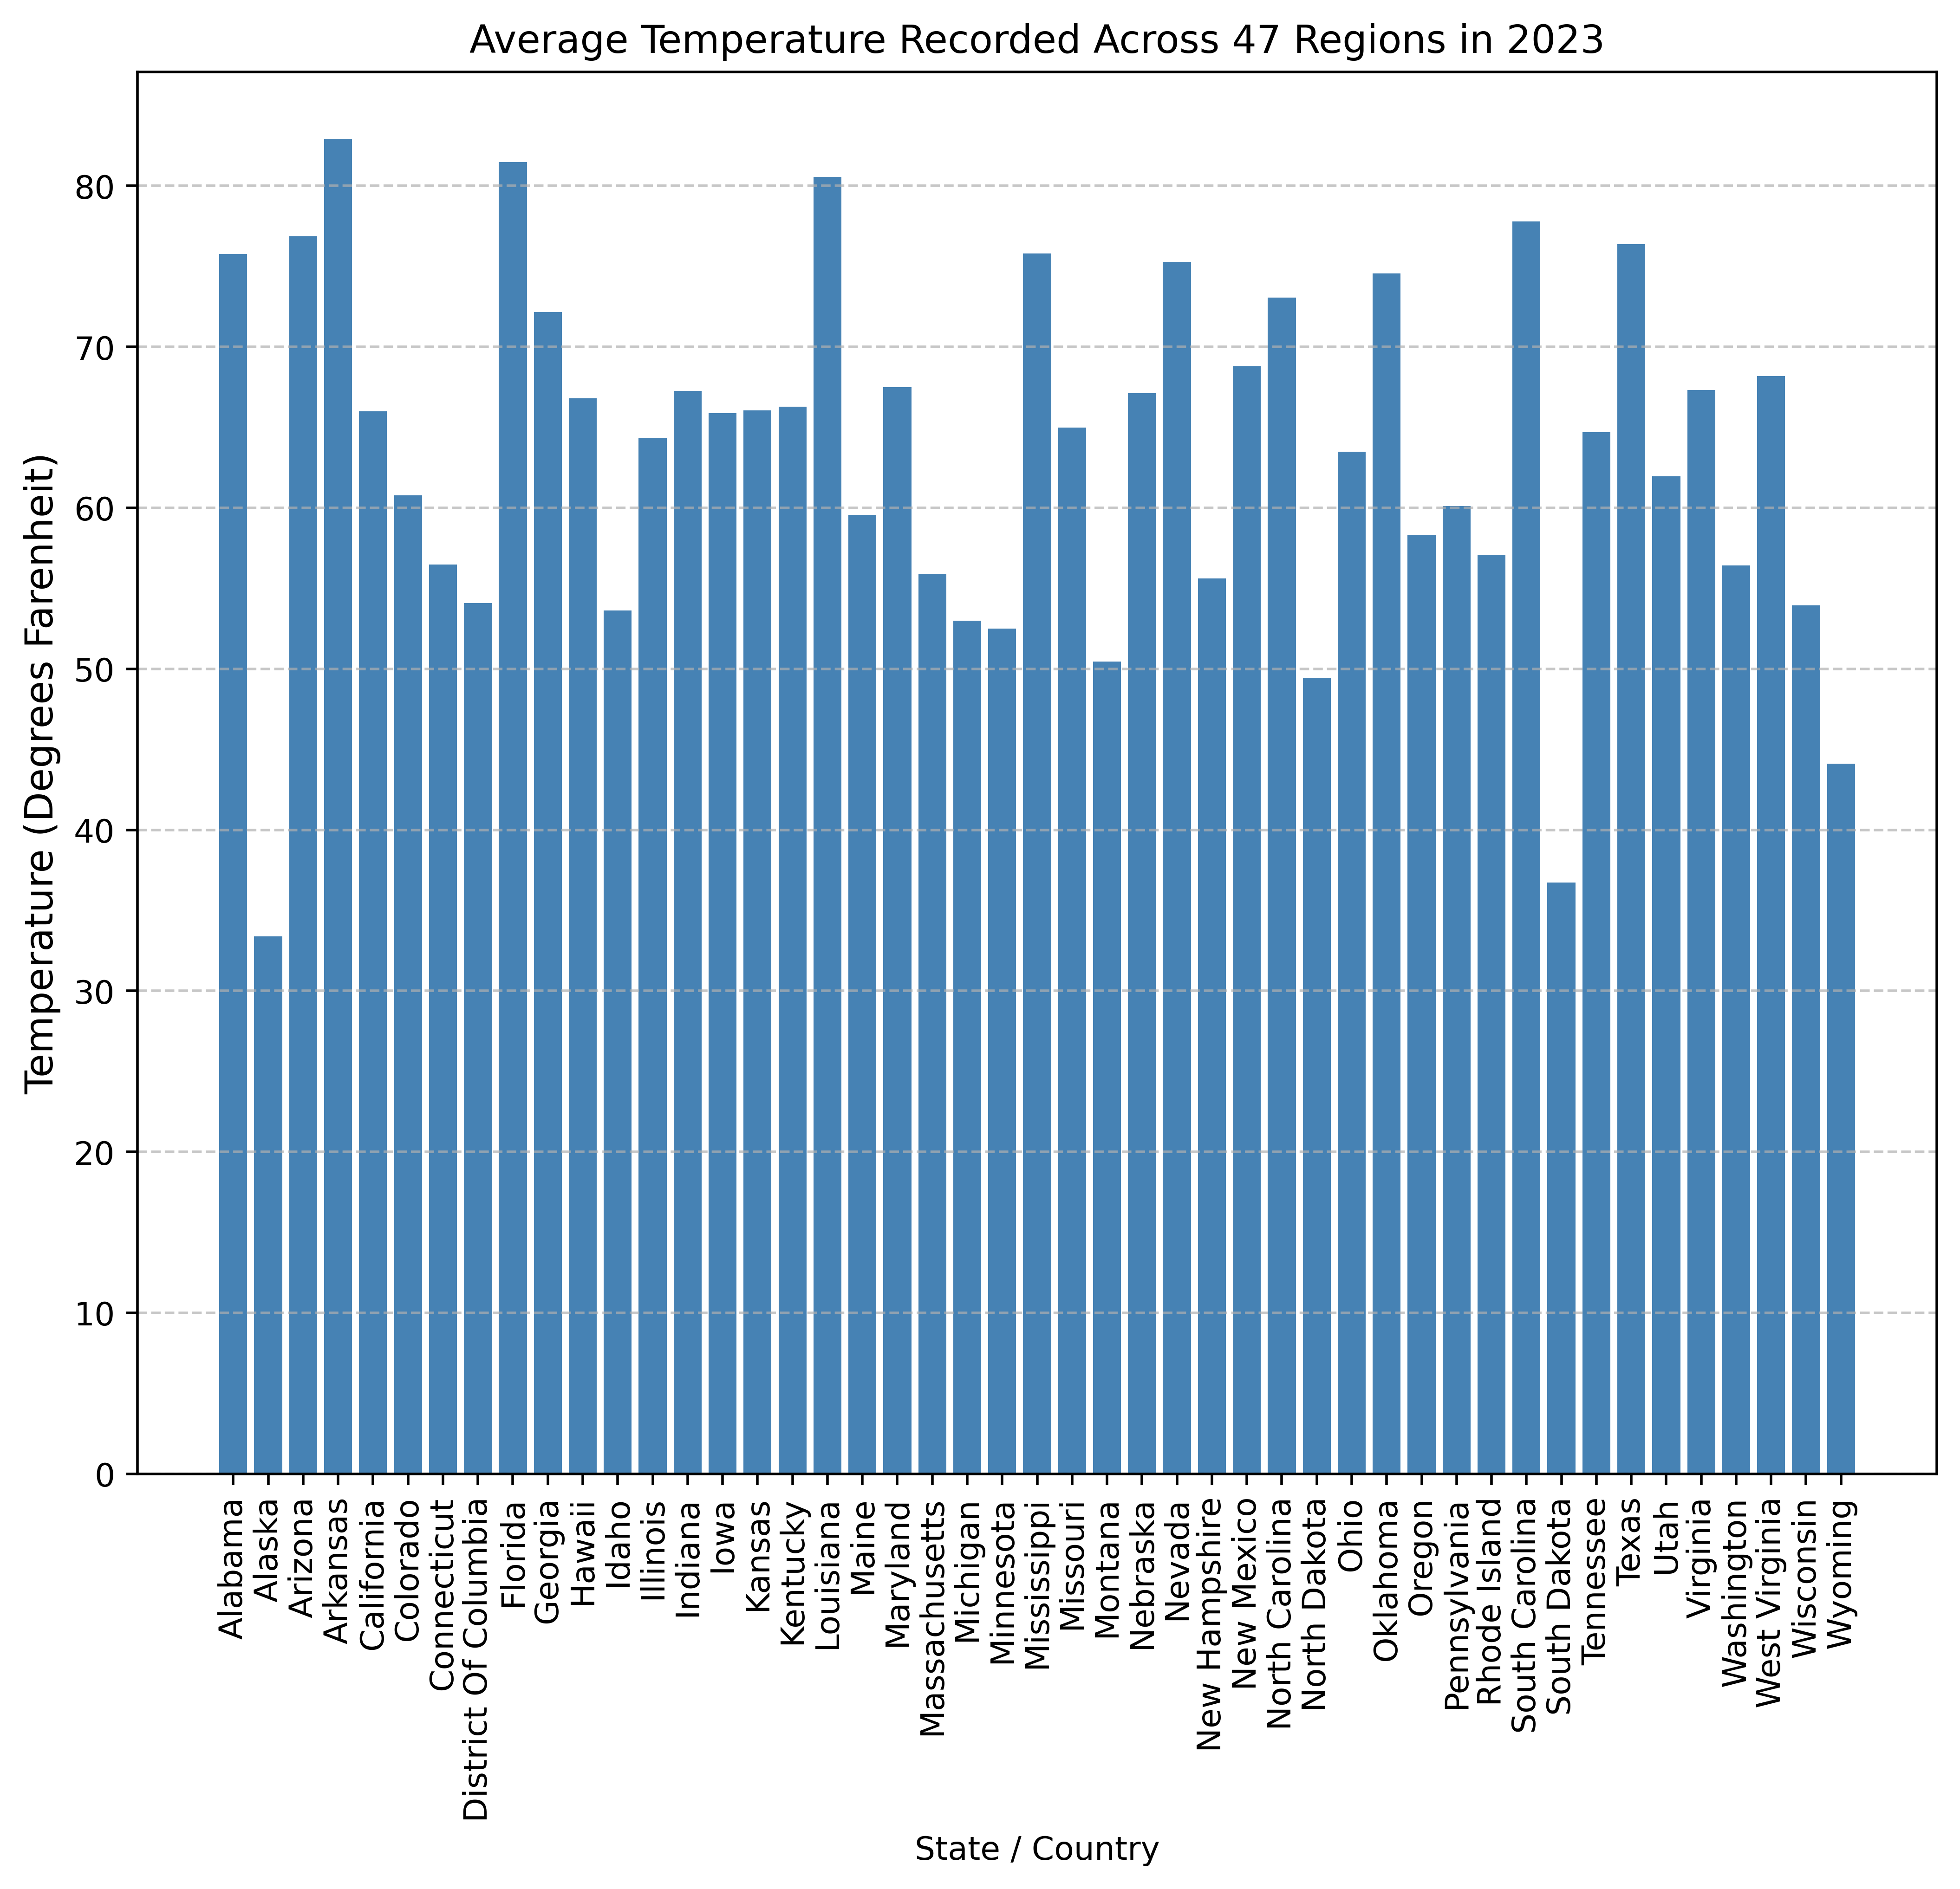

In [105]:
# Test function
temp_states_plot(file2, '2023')